In [1]:
import json
from datetime import datetime
import numpy as np
import pandas as pd
import ast
import torch
from torch.utils.data import DataLoader,Dataset

In [ ]:
def datacsv2dl(img,cgm,viome,lbl):
    class dataset(Dataset):
        def __init__(self, data, labels):
            self.data = data
            self.labels = labels

        def __len__(self):
            return len(self.data)

        def __getitem__(self, idx):
            d = torch.tensor(self.data.iloc[idx][self.data.columns.difference(['Subject ID','Day'])])
            label = torch.tensor(self.labels.iloc[idx][self.labels.difference(['Subject ID','Day'])], dtype=torch.int32)
            return d, label
    
    img_data = pd.read_csv(img)
    img_data['Image Before Breakfast'] = img_data['Image Before Breakfast'].apply(ast.literal_eval).apply(np.array)
    img_data['Image Before Lunch'] = img_data['Image Before Lunch'].apply(ast.literal_eval).apply(np.array)

    cgm_data = pd.read_csv(cgm)
    cgm_data['Breakfast Time'] = pd.to_datetime(cgm_data['Breakfast Time'], errors='coerce')
    cgm_data['Lunch Time'] = pd.to_datetime(cgm_data['Lunch Time'], errors='coerce')
    cgm_data['CGM Data'] = cgm_data['CGM Data'].apply(ast.literal_eval)
    for _, row in cgm_data.iterrows():
        for i, t in enumerate(row['CGM Data']):
            row['CGM Data'][i] = (datetime.strptime(t[0], '%Y-%m-%d %H:%M:%S'), t[1:])

    viome_data = pd.read_csv(viome)
    viome_data['Viome'] = viome_data['Viome'].apply(ast.literal_eval).apply(np.array)

    data = img_data.merge(cgm_data, on=['Subject ID','Day'])
    data = data.merge(viome_data, on=['Subject ID'])

    labels = pd.read_csv(lbl)
    if lbl[-8:]=='only.csv':
        labels = data.merge(labels, on=['Subject ID','Day'])[['Breakfast Calories','Breakfast Carbs','Breakfast Fat','Breakfast Protein']]
    else:
        labels = data.merge(labels, on=['Subject ID','Day'])[['Breakfast Calories','Lunch Calories','Breakfast Carbs','Lunch Carbs','Breakfast Fat','Lunch Fat','Breakfast Protein','Lunch Protein']]
    
    ds = dataset(data,labels)
    return data, ds, DataLoader(ds, batch_size=32, shuffle=True)

In [3]:
data_train, train_ds, train_dl = datacsv2dl(
    '../data/img_train.csv',
    '../data/cgm_train.csv',
    '../data/demo_viome_train.csv',
    '../data/label_train.csv'
    )
data_test, test_ds, test_dl = datacsv2dl(
    '../data/img_test.csv',
    '../data/cgm_test.csv',
    '../data/demo_viome_test.csv',
    '../data/label_test_breakfast_only.csv'
    )


In [6]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 324 entries, 0 to 323
Data columns (total 26 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Subject ID                324 non-null    int64         
 1   Day                       324 non-null    int64         
 2   Image Before Breakfast    324 non-null    object        
 3   Image Before Lunch        324 non-null    object        
 4   Breakfast Time            298 non-null    datetime64[ns]
 5   Lunch Time                300 non-null    datetime64[ns]
 6   CGM Data                  324 non-null    object        
 7   Age                       324 non-null    int64         
 8   Gender                    324 non-null    int64         
 9   Weight                    324 non-null    float64       
 10  Height                    324 non-null    float64       
 11  Race                      324 non-null    object        
 12  Diabetes Status       

In [5]:
data_train.head()

,Subject ID,Day,Image Before Breakfast,Image Before Lunch,Breakfast Time,Lunch Time,CGM Data,Age,Gender,Weight,...,Triglycerides,Cholesterol,HDL,Non-HDL,LDL,VLDL,CHO/HDL Ratio,HOMA-IR,BMI,Viome
0,1,2,"[[[140, 122, 108], [135, 118, 104], [118, 104,...","[[[41, 152, 201], [77, 164, 205], [88, 157, 13...",2021-09-19 08:41:00,2021-09-19 12:24:00,"[(2021-09-19 08:20:00, (98.26666666666667,)), ...",27,0,133.8,...,67.0,216.0,74.0,142.0,130.0,13.0,2.9,0.561728,22.263053,"[-11.691621427726268, -7.744787588227839, -7.6..."
1,1,3,"[[[67, 58, 47], [59, 52, 41], [51, 45, 35], [4...","[[[40, 59, 77], [35, 56, 72], [20, 36, 47], [9...",2021-09-20 09:50:00,2021-09-20 15:20:00,"[(2021-09-20 09:10:00, (97.18333333333334,)), ...",27,0,133.8,...,67.0,216.0,74.0,142.0,130.0,13.0,2.9,0.561728,22.263053,"[-11.691621427726268, -7.744787588227839, -7.6..."
2,1,4,"[[[199, 195, 193], [198, 193, 192], [196, 192,...","[[[53, 44, 38], [51, 43, 36], [54, 47, 39], [4...",2021-09-21 09:34:00,2021-09-21 13:09:00,"[(2021-09-21 09:20:00, (107.36666666666666,)),...",27,0,133.8,...,67.0,216.0,74.0,142.0,130.0,13.0,2.9,0.561728,22.263053,"[-11.691621427726268, -7.744787588227839, -7.6..."
3,1,5,"[[[149, 121, 80], [157, 128, 86], [159, 130, 8...","[[[30, 28, 28], [20, 18, 17], [31, 27, 23], [2...",2021-09-22 09:46:00,2021-09-22 13:50:00,"[(2021-09-22 09:25:00, (107.28333333333333,)),...",27,0,133.8,...,67.0,216.0,74.0,142.0,130.0,13.0,2.9,0.561728,22.263053,"[-11.691621427726268, -7.744787588227839, -7.6..."
4,1,6,"[[[175, 184, 198], [192, 206, 219], [160, 165,...","[[[74, 85, 100], [59, 69, 81], [73, 84, 96], [...",2021-09-23 09:07:00,2021-09-23 13:17:00,"[(2021-09-23 08:55:00, (103.0,)), (2021-09-23 ...",27,0,133.8,...,67.0,216.0,74.0,142.0,130.0,13.0,2.9,0.561728,22.263053,"[-11.691621427726268, -7.744787588227839, -7.6..."


In [9]:
from image_captioning import generate_caption

In [10]:
# Apply the captioning function to each row
data_train["Caption Before Lunch"] = data_train["Image Before Lunch"].apply(generate_caption)
data_train["Caption Before Breakfast"] = data_train["Image Before Breakfast"].apply(generate_caption)

c:\Users\Omar\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\generation\utils.py:1375: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
c:\Users\Omar\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\generation\utils.py:1375: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


In [13]:
data_train["Caption Before Lunch"]

0                    a table with a plate and some glass
1               a woman in a pink dress and a blue dress
2      a man in a white shirt and tie is holding a pi...
3                           a box of blue and white rice
4                a blue and white wall with a hole in it
                             ...                        
319                 a blue plate with a blue plate cover
320       a diamond ring with a blue stone in the center
321    a white and blue object with a black and white...
322              a blue and purple flower in a blue bowl
323                    a plate with a piece of ice on it
Name: Caption Before Lunch, Length: 324, dtype: object

In [20]:
import matplotlib.pyplot as plt
from textwrap import wrap

def plot_samples(data, num_samples=5):
    """
    Plot images and captions for a random subset of samples from the DataFrame.
    Ensures invalid images are skipped, and valid ones are chosen instead.

    Args:
    - data (pd.DataFrame): The DataFrame containing image and caption data.
    - num_samples (int): Number of samples to plot.

    Returns:
    - None: Displays the plot.
    """
    valid_data = data[
        data["Image Before Lunch"].apply(lambda x: x.shape != (0,)) &
        data["Image Before Breakfast"].apply(lambda x: x.shape != (0,))
    ]

    if len(valid_data) < num_samples:
        raise ValueError("Not enough valid samples to display")

    # Randomly sample valid rows from the DataFrame
    sampled_data = valid_data.sample(n=num_samples)

    # Create a plot with two columns: one for lunch and one for breakfast
    fig, axes = plt.subplots(num_samples, 2, figsize=(20, num_samples * 5))

    # Set column titles
    fig.suptitle("Lunch Caption (Left) | Breakfast Caption (Right)", fontsize=16, y=0.92)

    for i, (_, row) in enumerate(sampled_data.iterrows()):
        # Plot "Image Before Lunch"
        axes[i, 0].imshow(row["Image Before Lunch"])
        axes[i, 0].axis('off')
        lunch_caption = "\n".join(wrap(row['Caption Before Lunch'], width=40))
        axes[i, 0].set_title(lunch_caption, fontsize=10)

        # Plot "Image Before Breakfast"
        axes[i, 1].imshow(row["Image Before Breakfast"])
        axes[i, 1].axis('off')
        breakfast_caption = "\n".join(wrap(row['Caption Before Breakfast'], width=40))
        axes[i, 1].set_title(breakfast_caption, fontsize=10)

    # Adjust layout
    plt.tight_layout(rect=[0, 0, 1, 0.9])  # Leave space for the main title
    plt.show()

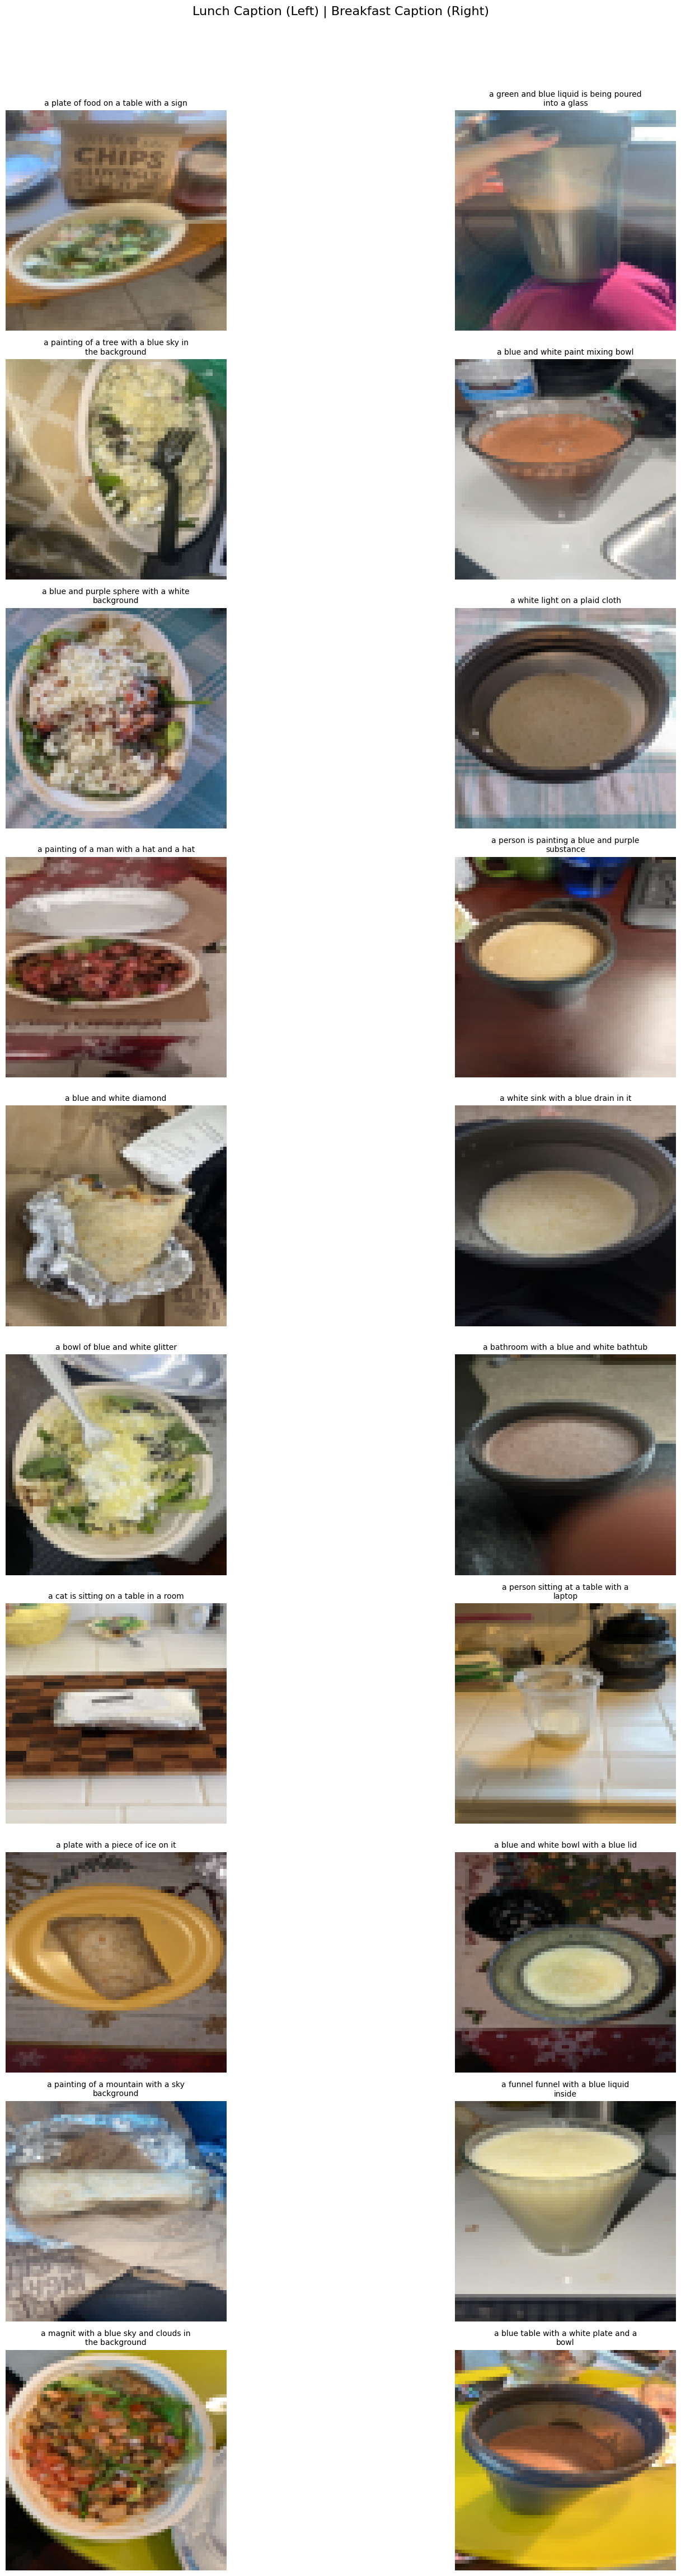

In [21]:
plot_samples(data_train, num_samples=10)